---
title: "Beverages Sales Analysis"
author: Nikhil Pundir
echo: false
warning: false
format: 
  html: 
    theme: cosmo
    embed-resources: true
    page-layout: full
    toc: true
    sidebar:
      style: floating
      collapse-level: 2
      pinned: true
  

---

| Section      | Details                                                  |
|--------------|----------------------------------------------------------|
| Tools Used   | Python (Pandas, Matplotlib), SQL, Quarto                 |
| Data Source  | Internal transaction database                            |


## Report Overview
This report analyzes sales data from a coffee shop over a given period, focusing on beverage transactions. The goal is to identify best-selling products, revenue trends, and store performance by location. Using SQL and Python, we extracted and processed transaction-level data to create visual summaries. Key findings are framed using the QIA method to drive actionable decisions, such as stocking strategies, pricing adjustments, and targeted promotions

:::{.content-hidden}
Importing libraries
:::

In [1]:
import pandas as pd 
import numpy as numpy
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

:::{.content-hidden}
Sqlite3 connection with database
:::

### Sample Data

This dataset contains transaction-level sales data collected from multiple beverages shop locations. Each row represents a unique transaction, with details such as the product sold, quantity, price, date, and time of purchase.

In [2]:
import itables
con = sqlite3.connect('coffee.db')
df = pd.read_sql('select * from coffeshop',con)
itables.show(df.sample(50))

Loading ITables v2.4.4 from the internet... (need help?)


:::{.content-hidden}
Data Preprocessing
:::

In [3]:
df["transaction_date"] = df['transaction_date'].astype("datetime64[ns]")
df["transaction_time"] = pd.to_datetime(df['transaction_time']).dt.time
df.duplicated(subset = 'transaction_id').unique()
df["total_revenue"] = df["unit_price"] * df["transaction_qty"]

C:\Users\nikhi\AppData\Local\Temp\ipykernel_10380\3723947686.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



### Which store location generated the highest total revenue over time?
Hells Kitchen generated the highest total revenue at 236K, followed closely by Astoria 232K and Lower Manhattan 230K. The revenue distribution among these top three stores is very close, indicating a balanced performance across key locations.

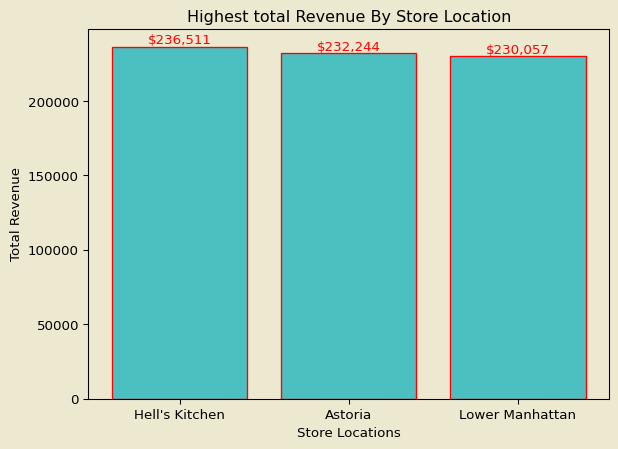

In [4]:
rev = df.groupby('store_location')['total_revenue'].sum().reset_index().sort_values(by = 'total_revenue', ascending = False)
plt.figure(facecolor = '#ede9d0')
plt.gca().set_facecolor("#ede9d0")
plt.bar(rev['store_location'], rev['total_revenue'] , color = "#4CC0C0", edgecolor = "red")
plt.xlabel("Store Locations")
plt.ylabel("Total Revenue")
plt.title("Highest total Revenue By Store Location")
for i, value in enumerate(rev['total_revenue']):
    plt.text(i, value , f"${value:,.0f}", ha='center', va='bottom', color = "red")
plt.show()

### How does sales volume (quantity) trend over months?
Sales volume shows a strong upward trend over time. In January, total quantity sold was around 24K units, and it steadily increased to 50K units by June. This indicates growing customer demand or improved business performance over the months.

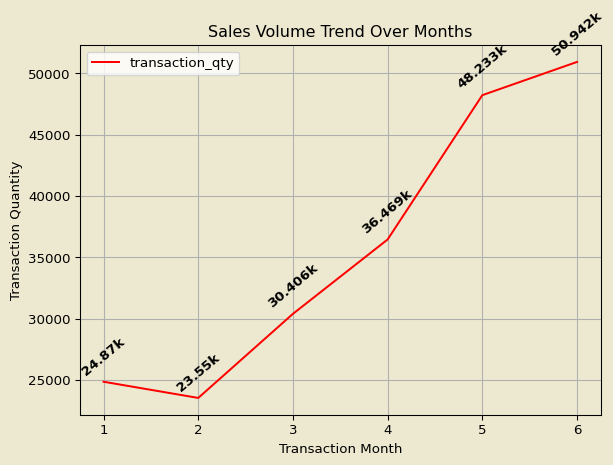

In [5]:
df["transaction_month"]= pd.to_datetime(df["transaction_date"]).dt.month
vol = df.groupby("transaction_month")["transaction_qty"].sum().reset_index().sort_values(by = "transaction_month")
ax = vol.plot(x = "transaction_month", y = "transaction_qty", kind = "line", color = "red")
fig = plt.gcf()
fig.set_facecolor("#ede9d0")  
ax.set_facecolor("#ede9d0")
plt.grid(True)
plt.title("Sales Volume Trend Over Months")
plt.xlabel("Transaction Month")
plt.ylabel("Transaction Quantity")
for i, value in enumerate(vol["transaction_qty"]):
  plt.text(i+1, value+300 , f"{value/1000}k", ha = "center", va = "bottom", color = "black", rotation = 40, fontweight = "bold")
plt.show()

### Which product categories bring in the most revenue?
Coffee is the top revenue-generating category with 270K, followed by Tea 196K, Bakery 82K, and King Chocolate 72K. The lowest revenue comes from Packed Chocolate, contributing only ₹4K. This highlights coffee and tea as the dominant contributors to overall sales.

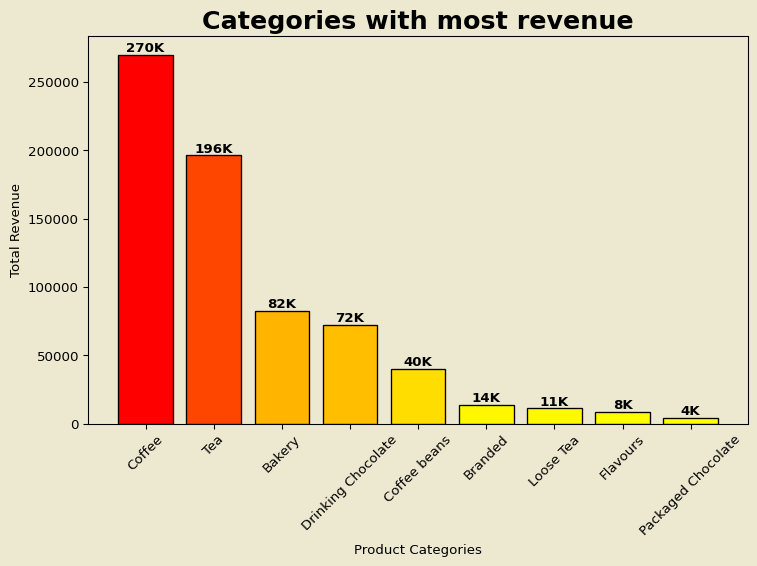

In [6]:
pie = df.groupby("product_category")["total_revenue"].sum().reset_index().sort_values(by = "total_revenue", ascending = False)
plt.figure(figsize = (8,6), facecolor = "#ede9d0")
plt.gca().set_facecolor("#ede9d0")
norm = plt.Normalize(pie["total_revenue"].min(), pie["total_revenue"].max())
colors = cm.autumn_r(norm(pie["total_revenue"]))
plt.bar(pie["product_category"], pie["total_revenue"], color = colors, edgecolor = "black")
plt.title("Categories with most revenue", fontsize = 19, fontweight = "bold")
plt.xlabel("Product Categories")
plt.ylabel("Total Revenue")
plt.xticks(rotation = 45)
plt.tight_layout()
for i, value in enumerate(pie["total_revenue"]):
  plt.text(i, value, f"{round(value/1000)}K", color = "black", fontweight = "bold", ha = "center", va = "bottom")
plt.show()

### What are the top best-selling products across all stores?

* In Astoria, the best-selling product is Dark Chocolate.

* In Hells Kitchen, it's Civet Cat Coffee.

* In Lower Manhattan, again, Dark Chocolate leads in sales.

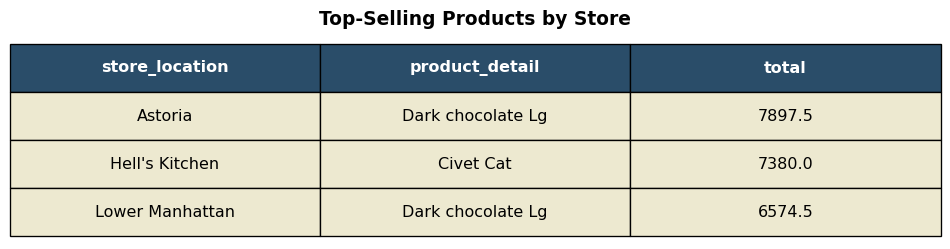

In [7]:
bsp = pd.read_sql('''
with cte as (
select
store_location,
product_detail,
sum(transaction_qty*unit_price) as total,
row_number()over(partition by store_location order by sum(transaction_qty * unit_price) desc) as rw
from coffeshop
group by store_location, product_detail
)
select
store_location, product_detail, total from cte where rw = 1
''',con)
bsp
fig, ax = plt.subplots(figsize=(10,2.7))
ax.axis('off')  

table = ax.table(
    cellText=bsp.values,
    colLabels=bsp.columns,
    loc='center',
    cellLoc='center'
)
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#2a4d69')
    else:
        cell.set_facecolor('#ede9d0')
table.scale(1, 3)
table.auto_set_font_size(False)
table.set_fontsize(12)
plt.title("Top-Selling Products by Store", fontsize=14, weight='bold', pad=12)
plt.tight_layout()
plt.show()

### How does revenue vary by time of day (morning, afternoon, evening)?
The highest revenue comes from morning hours, contributing 43.3% of total sales. This is followed by evening (23.4%), afternoon (20.6%), and night (12.6%). This pattern suggests that customers are most active during mornings, likely for their daily coffee routines.


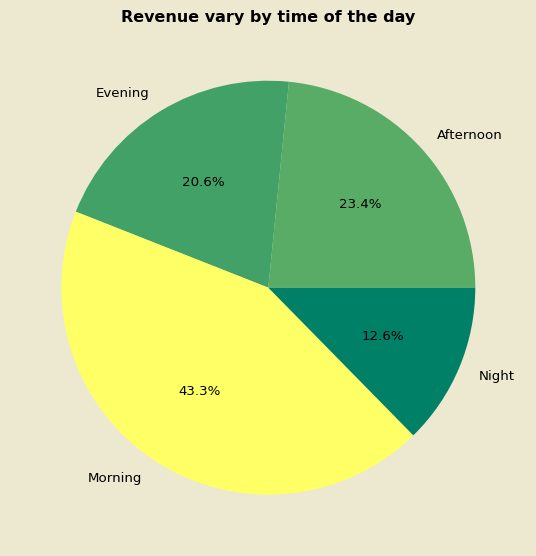

In [8]:

def tod(x):
  hours = x.hour
  if 8 <= hours <= 11:
    return "Morning"
  elif 11< hours <= 15:
    return "Afternoon"
  elif 15 < hours <= 19:
    return "Evening"
  else:
    return "Night"
df["time of day"] = df["transaction_time"].apply(tod)
totd = df.groupby("time of day")["total_revenue"].sum().reset_index().sort_values(by = "time of day")
plt.figure(figsize=(7,7), facecolor = "#ede9d0")
norm = plt.Normalize(totd["total_revenue"].min(), totd["total_revenue"].max())
colors = cm.summer(norm(totd["total_revenue"]))
plt.title("Revenue vary by time of the day", fontweight = "bold")
plt.pie(totd["total_revenue"], labels = totd["time of day"], autopct='%1.1f%%', colors = colors,)
plt.show()

### Which store has the highest average transaction value?
Lower Manhattan has the highest average transaction value at 4.81, followed by Hells Kitchen (4.66) and Astoria (4.59). While the difference is small, it suggests customers in Lower Manhattan tend to purchase slightly more or opt for higher-priced items per visit.

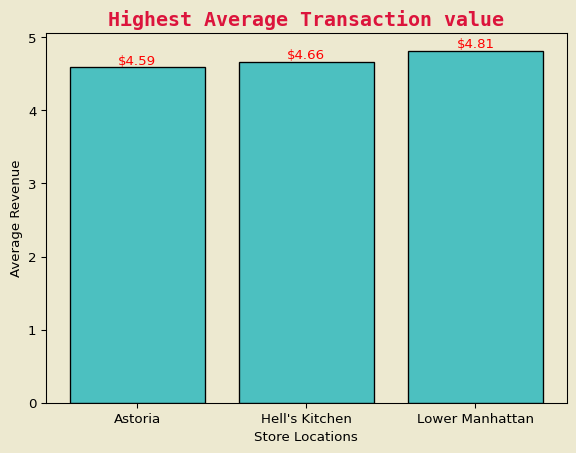

In [9]:

df.head(1)
hat = df.groupby("store_location")["total_revenue"].mean().reset_index().sort_values(by = "total_revenue")
plt.figure(facecolor = "#ede9d0")
plt.bar(hat['store_location'], hat['total_revenue'] , color = "#4CC0C0", edgecolor = "black")
plt.xlabel("Store Locations")
plt.ylabel("Average Revenue")
plt.gca().set_facecolor("#ede9d0")
plt.title("Highest Average Transaction value", color = "crimson", fontsize = 15, fontfamily = "Monospace", fontweight = "bold")
for i, value in enumerate(hat['total_revenue']):
    plt.text(i, value , f"${round(value,2)}", ha='center', va='bottom', color = "red")
plt.show()

### What is the hourly transaction pattern across all stores?
Transactions gradually increase during early hours and peak between 6 AM and 10 AM, aligning with typical morning coffee demand. There's a smaller secondary rise around 2 PM to 5 PM, likely due to post-work or evening relaxation purchases. Activity drops significantly during late-night hours.

--------------------------------------------------------------


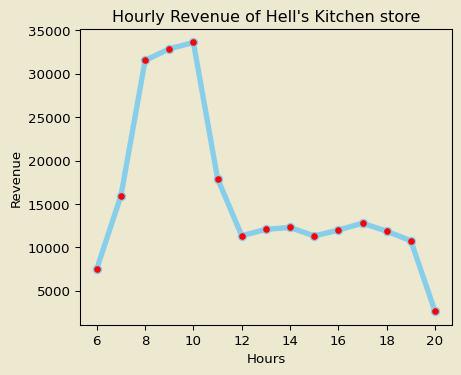

--------------------------------------------------------------


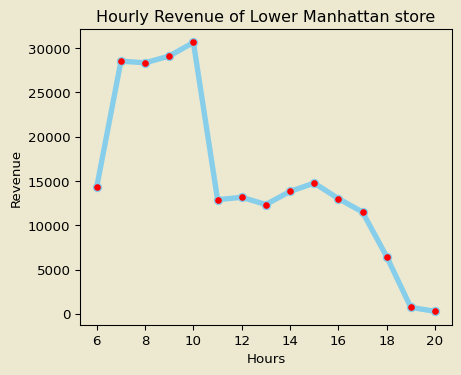

--------------------------------------------------------------


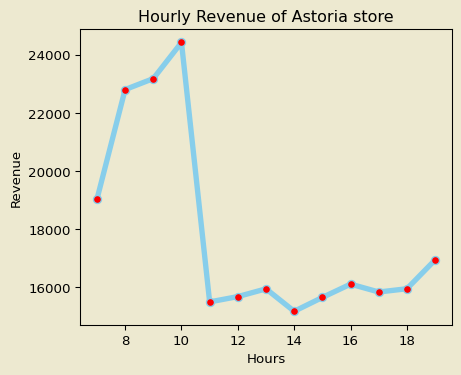

In [10]:
#What is the hourly transaction pattern across all stores?
df.head(1)
htp = df[["total_revenue", "store_location","transaction_time"]].copy()
htp["transaction_time"] = htp["transaction_time"].apply(lambda x: x.hour).reset_index(drop = True)
htp2 = htp.groupby(["store_location","transaction_time"])["total_revenue"].sum().reset_index().sort_values(by = "transaction_time")
store = htp2["store_location"].unique()

for i in store:
    plt.figure(figsize = (5,4), facecolor = "#ede9d0")
    plt.gca().set_facecolor("#ede9d0")
    final = htp2[i == htp2["store_location"]]
    hourly_rev = final.groupby("transaction_time")["total_revenue"].sum().reset_index()
    plt.plot(hourly_rev["transaction_time"], hourly_rev["total_revenue"], color = "skyblue", marker = "o", markerfacecolor = "red", linewidth = 4)
    plt.xlabel("Hours")
    plt.ylabel("Revenue")
    plt.title(f"Hourly Revenue of {i} store")
    print("--------------------------------------------------------------")
    plt.show()

### How does the popularity of each product category differ by store?
Across all store locations, the top four product categories are consistently Coffee, Tea, Bakery, and Drinking Chocolate. This indicates that customer preferences are relatively uniform regardless of location, with beverages (especially coffee and tea) dominating sales

----------------------------------------------------------------------------


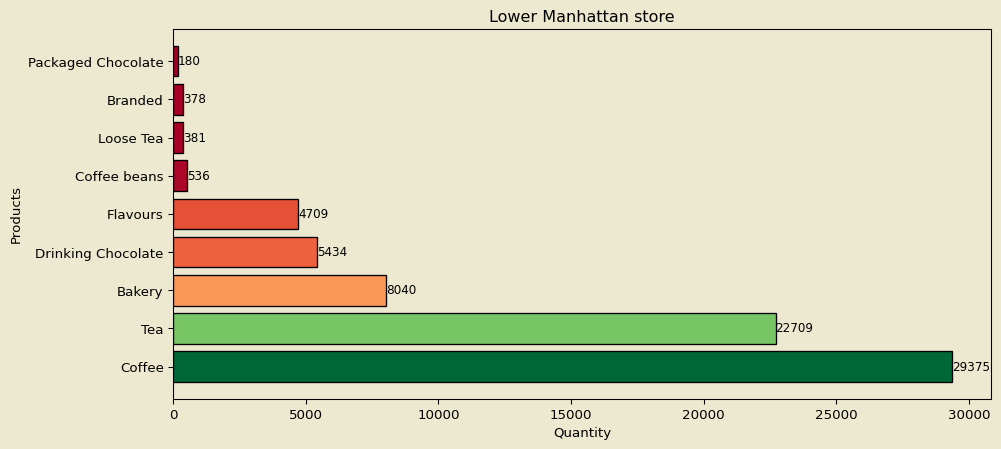

----------------------------------------------------------------------------


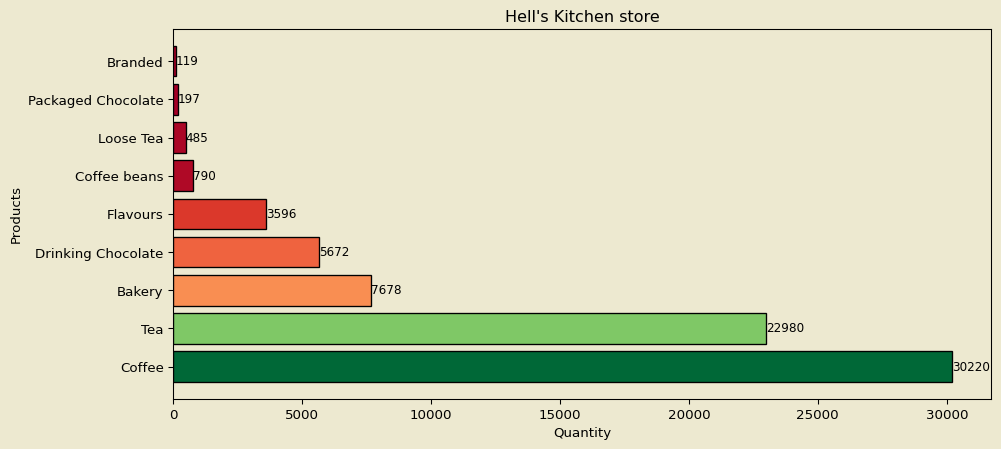

----------------------------------------------------------------------------


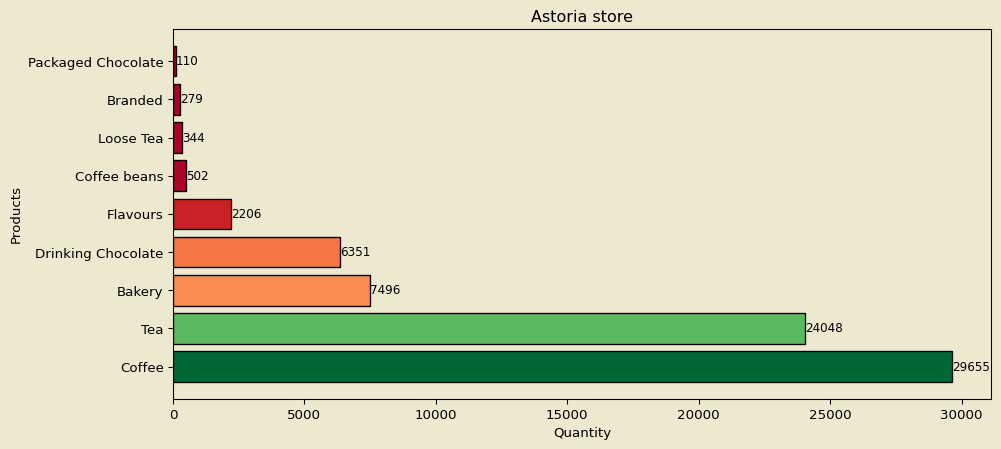

In [11]:
stores = df["store_location"].unique()
for store in stores:
  store_data = df[df["store_location"] == store]
  final = store_data.groupby(["store_location","product_category"])["transaction_qty"].sum().reset_index().sort_values(by = "transaction_qty", ascending = False)
  norm = plt.Normalize(final["transaction_qty"].min(), final["transaction_qty"].max())
  colors = cm.RdYlGn(norm(final["transaction_qty"]))
  plt.figure(figsize = (11,5), facecolor = "#ede9d0")
  plt.gca().set_facecolor("#ede9d0")
  plt.barh(final["product_category"], final["transaction_qty"], color = colors, edgecolor = "black")
  plt.xlabel("Quantity")
  plt.ylabel("Products")
  plt.title(f"{store} store")
  print("----------------------------------------------------------------------------")
  for index, value in enumerate(final["transaction_qty"]):
      plt.text(value + 1, index, str(value), va='center', ha = 'left', fontsize=9)
  plt.show()

:::{.content-hidden}
Total revenue Prediction for a transaction based on store location, time of day
:::

In [12]:
#correlation matrix
# corm = df.corr(numeric_only= True)
# sns.heatmap(corm, annot = True, cmap = 'coolwarm')
# plt.title("Correlation matrix")
# plt.show()

In [13]:
# dff = pd.get_dummies(df, columns = ['store_location', 'time of day', 'product_detail'])
# dff.drop(columns="transaction_time_str", inplace = True)

In [14]:
# x = dff.drop(columns = ['transaction_id', 'transaction_date', 
#        'transaction_qty', 'store_id', 'product_id', 'unit_price'
#        , 'total_revenue','product_category', 'product_type', 'transaction_time'])
# y = dff["total_revenue"]


In [15]:
#train test splitting
# x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

In [16]:
#scaling
# scaler = StandardScaler()
# x_train_scale = scaler.fit_transform(x_train)
# x_test_scale = scaler.fit_transform(x_test)

In [17]:
#train model
# lr = LinearRegression()
# lr.fit(x_train_scale, y_train)

In [18]:
#evaluation and prediction
# y_pred = lr.predict(x_test_scale)
# score = r2_score(y_test, y_pred)
# print("r2 score is ", score)

## Summary and Recommendations
* Hells Kitchen topped in revenue, but all three major stores (Hells Kitchen, Astoria, Lower Manhattan) performed similarly — keep pushing promotions evenly across them.

* Sales are rising month by month, doubling from Jan to June — plan ahead for even higher demand in the coming months.

* Mornings drive the most sales (43%), especially between 9–11 AM — make sure your team and stock are ready before the rush.

* Coffee and Tea dominate revenue, while Dark Chocolate and Civet Cat are top individual products — focus promos and bundles around these.

* Customer tastes are similar across locations — no need to over-customize. Keep your winning categories consistent and experiment with new product bundles to boost average sales.